Предварительно сменить с CPU на GPU (Среда выполнения -> Сменить среду выполнения -> T4 GPU ). Не ломается при следующих данных  batch_size = 4  # сколько примеров показывем модели за один шаг
report_steps = 200  # раз в сколько шагов печатаем результат
epochs = 3  # сколько раз мы покажем данные модели

In [ ]:
!pip install transformers sentencepiece

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
import random
from tqdm.auto import tqdm, trange
import os
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://huggingface.co/0x7o/keyt5-large

Cloning into 'keyt5-large'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80 (from 1)
Unpacking objects: 100% (80/80), 11.33 KiB | 374.00 KiB/s, done.
Filtering content: 100% (3/3), 5.49 GiB | 138.85 MiB/s, done.


### Проверка работы модели с базовыми требованиями

In [ ]:
# from itertools import groupby
# import torch
# from transformers import T5ForConditionalGeneration, T5Tokenizer
# model_name = "0x7194633/keyt5-large" # or 0x7194633/keyt5-base
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = T5ForConditionalGeneration.from_pretrained(model_name)

# def generate(text, **kwargs):
#     inputs = tokenizer(text, return_tensors='pt')
#     with torch.no_grad():
#         hypotheses = model.generate(**inputs, num_beams=5, **kwargs)
#     s = tokenizer.decode(hypotheses[0], skip_special_tokens=True)
#     s = s.replace('; ', ';').replace(' ;', ';').lower().split(';')[:-1]
#     s = [el for el, _ in groupby(s)]
#     return s

# article = """Reuters сообщил об отмене 3,6 тыс. авиарейсов из-за «омикрона» и погоды
# Наибольшее число отмен авиарейсов 2 января пришлось на американские авиакомпании
# SkyWest и Southwest, у каждой — более 400 отмененных рейсов. При этом среди
# отмененных 2 января авиарейсов — более 2,1 тыс. рейсов в США. Также свыше 6400
# рейсов были задержаны."""

# print(generate(article, top_p=1.0, max_length=64))
# # ['авиаперевозки', 'отмена авиарейсов', 'отмена рейсов', 'отмена авиарейсов', 'отмена рейсов', 'отмена авиарейсов']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

['авиаперевозки', 'отмена авиарейсов', 'отмена рейсов', 'отмена авиарейсов', 'отмена рейсов', 'отмена авиарейсов']


### Обучение модели на 3000 тыс данных

Предварительно загружаем датасет

In [ ]:
df = pd.read_csv('/content/dataset.csv')

In [ ]:
pd.options.display.max_colwidth = 500

In [ ]:
df.sample(5)

,X,Y
584,"По трубе 4 подают очищаемую жидкость, которая под действием центробежной силы равномерно распределяется внутри ротора 3 по его боковой перфорированной поверхности.",Центробежная сила; Жидкость;
108,"Благодаря большому углу 360° над поверхностью образца все количество света, отраженного и/или рассеянного с поверхности, перехватывается экраном, обеспечивая высокую чувствительность.",Изменение коэффициента отражения; Оптически прозрачный образец;
574,"Перемешиваемая среда циркулирует как через перфорированный диффузор 7 в осевом направлении, так и в радиальном направлении через отверстия перфораций в перфорированных цилиндре 6 и диффузоре 7, что способствует интенсивности перемешивания.",Интенсивность перемешивания; Перемешивающая среда;
306,В общем случае - процесс переработки газов с целью изменения состава исходной газовой смеси.,Изменение состава исходной газовой смеси;
291,Фрикционное взаимодействие (трение) - возникает при соприкосновении двух тел и препятствует их относительному движению.,Сила трения; Скорость движения;


Обучающая и тестовая выборка 50на50

In [ ]:
df_train, df_test = train_test_split(df.dropna(), test_size=0.2, random_state=1)
pairs = df_train[['X', 'Y']].values.tolist()

Инициализируем модель из предобученной ( Убрать .cuda() если используем CPU)

In [ ]:
raw_model = '0x7194633/keyt5-large' # или 0x7194633/keyt5-large
model = T5ForConditionalGeneration.from_pretrained(raw_model).cuda();
tokenizer = T5Tokenizer.from_pretrained(raw_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Заметки автора

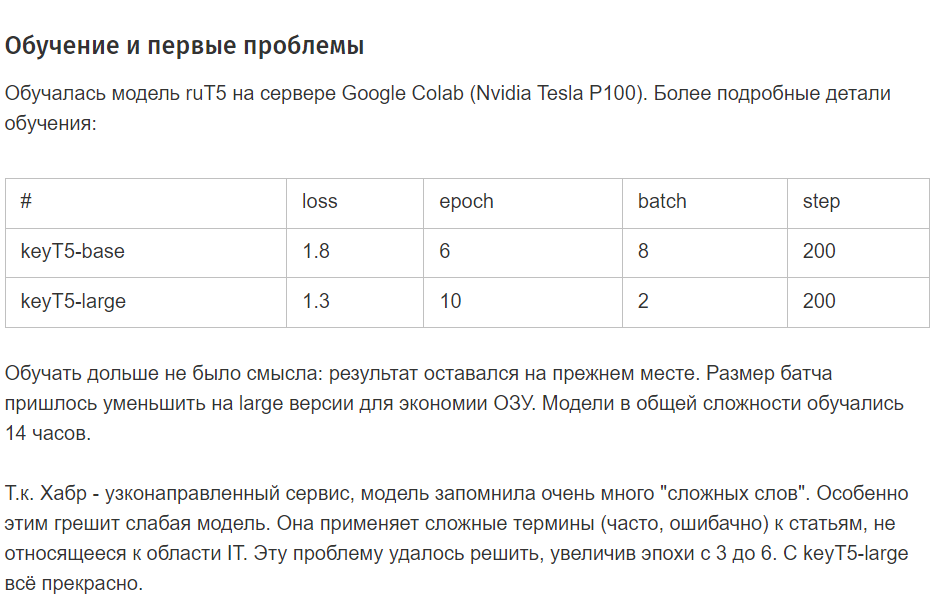

In [ ]:
batch_size = 2  # сколько примеров показывем модели за один шаг
report_steps = 200  # раз в сколько шагов печатаем результат
epochs = 10  # сколько раз мы покажем данные модели

In [ ]:
model.train()
losses = []
for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(pairs)
    for i in trange(0, int(len(pairs) / batch_size)):
        batch = pairs[i * batch_size: (i + 1) * batch_size]
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True).to(model.device)
        y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        loss = model(
            input_ids=x.input_ids,
            attention_mask=x.attention_mask,
            labels=y.input_ids,
            decoder_attention_mask=y.attention_mask,
            return_dict=True
        ).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 3.2268831729888916
step 200 loss 2.181491759568453
EPOCH 1


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 2.0144667227566244
step 200 loss 1.631275357156992
EPOCH 2


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 1.6370069314539433
step 200 loss 1.4169704133272172
EPOCH 3


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 1.3837650848925114
step 200 loss 1.2305593372881412
EPOCH 4


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 1.2291469743847847
step 200 loss 1.1175877649337054
EPOCH 5


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 1.08674256041646
step 200 loss 0.9881220331788063
EPOCH 6


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 0.9903279183059931
step 200 loss 0.8895944178849459
EPOCH 7


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 0.9080056838691235
step 200 loss 0.8092455309256912
EPOCH 8


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 0.7898942032828927
step 200 loss 0.6779725521430373
EPOCH 9


  0%|          | 0/234 [00:00<?, ?it/s]

step 0 loss 0.6915494333766401
step 200 loss 0.6244413240253925


In [ ]:
model.eval()

def answer(x, **kwargs):
    inputs = tokenizer(x, return_tensors='pt').to(model.device)
    with torch.no_grad():
        hypotheses = model.generate(**inputs, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [ ]:
def generate(text):
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        hypotheses = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Оценка модели
pairs_test = df_test[['X', 'Y']].values.tolist()
model.eval()
predictions, true_labels = [], []
for pair in pairs_test:
    true_labels.append(pair[1])
    pred = generate(pair[0])
    predictions.append(pred)

precision = precision_score(true_labels, predictions, average='micro', zero_division=0)
recall = recall_score(true_labels, predictions, average='micro', zero_division=0)
f1 = f1_score(true_labels, predictions, average='micro', zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Precision: 0.0847457627118644
Recall: 0.0847457627118644
F1 Score: 0.0847457627118644


Посмотрим, насколько хорошо модель выучила свою тренировочную выборку.


In [ ]:
sample = df_train.sample(5)
for i, row in sample.iterrows():
    print(row.X)
    print('real:', row.Y)
    print('model: ', answer(row.X))
    print('---')

Конвективный массообмен - массообмен, обусловленный совместным действием конвективного переноса вещества (массы) и диффузии.
real: Диффузия вещества;


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


model:  Диффузия вещества;
---
В частности, блеск - характеристика свойства поверхности, отражающей свет, показывающая соотношение между интенсивностями света, зеркально отражённого от поверхности, и диффузного света.
real: Интенсивность падающего света; Изменение коэффициента отражения;
model:  Интенсивность падающего света;
---
Упругое рассеяние (Рэлеевское рассеяние) света - когерентное рассеяние света без изменения длины волны (называемое также упругим рассеянием) на частицах, неоднородностях или других объектах, когда частота рассеиваемого света существенно меньше собственной частоты рассеивающего объекта или системы, т.е. рассеяние света на объектах, размеры которых меньше его длины волны.
real: Свет; Длина волны; Сферические частицы;
model:  Свет;
---
В таких массовых расходомерах, сила реакции Кориолиса, действующая на массу движущейся текучей среды, переносится на сам трубопровод и проявляется как отклонение или смещение трубопровода в направлении вектора силы Кориолиса в плос

Теперь посмотрим, насколько хорошо модель справляется с ответами на вопросы, которые она не видела.

In [ ]:
sample = df_test.sample(5)
for i, row in sample.iterrows():
    print(row.X)
    print('real:', row.Y)
    print('model: ', answer(row.X))
    print('---')

Таким образом, зеркальный смеситель выполняет функцию двух элементов: разворот потока с его последующим увеличением на коллимирующее зеркало и его 400-кратное перемешивание.
real: Разворот потока; Коллимация; Перемешивание светового; Зеркальный смеситель.;
model:  Коллимирующее зеркало;
---
Эталонное излучение, используемое в предложенной схеме, дополнительно сдвигается на 40 МГц с помощью акустооптического модулятора.
real: Сдвиг лазерного излучения;
model:  ЭЛМ излучение;
---
При этом предлагаемое техническое решение (варианты) сконфигурировано таким образом, что центральное место в нем занимает излучатель, испускающий в противоположные стороны (пути) квантовые частицы в виде парных запутанных частиц.
real: Парные запутанные частицы; Квантовые частицы;
model:  Пара запутанных частиц;
---
Магнитокалорический эффект – магнитотепловое явление, возникающее при воздействии магнитного поля на вещество, обладающее магнитными свойствами, состоящее в изменении температуры (энтропии) магнитног

In [ ]:
# https://yandex.ru/patents/doc/RU216836U1_20230302
text = 'Полезная модель относится к области медицинской техники, в частности к массажным устройствам для ног. Релаксирующее устройство на основе нагревательных элементов содержит бокс, заполненный массирующим наполнителем в виде песка или песочной смеси, нагревательные элементы, устройство управления нагревательными элементами, панель управления нагревательными элементами, выполненная с возможностью выбора программы, времени и температуры работы нагревательных элементов. В корпусе бокса размещены нагревательные элементы, соединенные с устройством управления нагревательными элементами и панелью управления нагревательными элементами. Технический результат заключается в повышении эффективности воздействия на стопы ног в процессе проведения теплотерапии, улучшении процесса массажа. Достижение указанного технического результата обеспечивается за счёт управления процессом нагрева наполнителя в боксе с помощью нагревательных элементов. 1 з.п. ф-лы, 2 ил.'

for q in [text]:
    print(q)
    print()
    print(answer(q, do_sample=True, top_p=0.9))


Полезная модель относится к области медицинской техники, в частности к массажным устройствам для ног. Релаксирующее устройство на основе нагревательных элементов содержит бокс, заполненный массирующим наполнителем в виде песка или песочной смеси, нагревательные элементы, устройство управления нагревательными элементами, панель управления нагревательными элементами, выполненная с возможностью выбора программы, времени и температуры работы нагревательных элементов. В корпусе бокса размещены нагревательные элементы, соединенные с устройством управления нагревательными элементами и панелью управления нагревательными элементами. Технический результат заключается в повышении эффективности воздействия на стопы ног в процессе проведения теплотерапии, улучшении процесса массажа. Достижение указанного технического результата обеспечивается за счёт управления процессом нагрева наполнителя в боксе с помощью нагревательных элементов. 1 з.п. ф-лы, 2 ил.

Нагреватель; Наполнитель в виде песочной смес

Варианты ответов батч 4 эпох 3:
Полезная модель относится к области медицинской техники, в частности к массажным устройствам для ног. Релаксирующее устройство на основе нагревательных элементов содержит бокс, заполненный массирующим наполнителем в виде песка или песочной смеси, нагревательные элементы, устройство управления нагревательными элементами, панель управления нагревательными элементами, выполненная с возможностью выбора программы, времени и температуры работы нагревательных элементов. В корпусе бокса размещены нагревательные элементы, соединенные с устройством управления нагревательными элементами и панелью управления нагревательными элементами. Технический результат заключается в повышении эффективности воздействия на стопы ног в процессе проведения теплотерапии, улучшении процесса массажа. Достижение указанного технического результата обеспечивается за счёт управления процессом нагрева наполнителя в боксе с помощью нагревательных элементов. 1 з.п. ф-лы, 2 ил.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
повышение эффективности воздействия на стопы ног;

In [ ]:
new_model_name = 'keyT5-custom_fiz'  # название папки
model.save_pretrained(new_model_name)
tokenizer.save_pretrained(new_model_name)

('keyT5-custom_fiz/tokenizer_config.json',
 'keyT5-custom_fiz/special_tokens_map.json',
 'keyT5-custom_fiz/spiece.model',
 'keyT5-custom_fiz/added_tokens.json')

In [ ]:
import shutil
from google.colab import files

folder_path = '/content/keyT5-custom_fiz'

shutil.make_archive('/content/keyT5-custom_fiz', 'zip', folder_path)


'/content/keyT5-custom_fiz.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source_path = '/content/keyT5-custom_fiz.zip'
destinton_path = '/content/drive/My Drive/keyT5-custom_fiz.zip'

shutil.copy(source_path, destinton_path)

'/content/drive/My Drive/keyT5-custom_fiz.zip'

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
from tqdm.auto import tqdm

def compute_metrics(pred_labels, true_labels):
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    return precision, recall, f1

def evaluate_model(model, tokenizer, test_data):
    model.eval()
    predictions = []
    true_labels = []
    for example in tqdm(test_data):
        inputs = tokenizer(example[0], return_tensors='pt').to(model.device)
        with torch.no_grad():
            hypothesis = model.generate(**inputs, num_beams=5, max_new_tokens=50)  # Например, максимум 50 новых токенов
        predicted_label = tokenizer.decode(hypothesis[0], skip_special_tokens=True)
        predictions.append(predicted_label)
        true_labels.append(example[1])
    return compute_metrics(predictions, true_labels)

# Далее в коде обучения после завершения обучения вызовите функцию оценки:
precision, recall, f1 = evaluate_model(model, tokenizer, df_test[['X', 'Y']].values.tolist())
print(f'Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}')
